In [ ]:
#Import required libraries
import torch.nn as nn
import torch as tch
import numpy as np, pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score,roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/bank.csv')
print(df.shape)
df.head()

(11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [ ]:
df.deposit.value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

In [ ]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [ ]:
cat_columns = df.select_dtypes(include='object').columns

In [ ]:
for col in cat_columns:
  if df[col].nunique() == 2:
    df[col] = np.where(df[col] == 'yes', 1, 0)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,0,2343,1,0,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,0,45,0,0,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,0,1270,1,0,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,0,2476,1,0,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,0,184,0,0,unknown,5,may,673,2,-1,0,unknown,1


In [ ]:
new_df = pd.get_dummies(df)

In [ ]:
target = 'deposit'
predictors = set(new_df.columns) - set([target])
print("new_df.shape:",new_df.shape)
new_df[predictors].head()

new_df.shape: (11162, 49)


,education_tertiary,day,job_services,loan,education_primary,campaign,contact_telephone,month_jun,month_nov,job_management,month_jul,job_student,education_unknown,age,job_entrepreneur,month_may,poutcome_other,month_feb,poutcome_success,job_retired,duration,month_apr,job_blue-collar,education_secondary,month_oct,month_sep,poutcome_failure,contact_cellular,month_aug,marital_divorced,job_admin.,balance,contact_unknown,job_technician,marital_married,month_mar,job_self-employed,job_housemaid,pdays,marital_single,default,poutcome_unknown,job_unemployed,previous,housing,job_unknown,month_jan,month_dec
0,0,5,0,0,0,1,0,0,0,0,0,0,0,59,0,1,0,0,0,0,1042,0,0,1,0,0,0,0,0,0,1,2343,1,0,1,0,0,0,-1,0,0,1,0,0,1,0,0,0
1,0,5,0,0,0,1,0,0,0,0,0,0,0,56,0,1,0,0,0,0,1467,0,0,1,0,0,0,0,0,0,1,45,1,0,1,0,0,0,-1,0,0,1,0,0,0,0,0,0
2,0,5,0,0,0,1,0,0,0,0,0,0,0,41,0,1,0,0,0,0,1389,0,0,1,0,0,0,0,0,0,0,1270,1,1,1,0,0,0,-1,0,0,1,0,0,1,0,0,0
3,0,5,1,0,0,1,0,0,0,0,0,0,0,55,0,1,0,0,0,0,579,0,0,1,0,0,0,0,0,0,0,2476,1,0,1,0,0,0,-1,0,0,1,0,0,1,0,0,0
4,1,5,0,0,0,2,0,0,0,0,0,0,0,54,0,1,0,0,0,0,673,0,0,0,0,0,0,0,0,0,1,184,1,0,1,0,0,0,-1,0,0,1,0,0,0,0,0,0


In [ ]:
new_df = new_df.astype(np.float32)

In [ ]:
X_train,x_test, Y_train,y_test = train_test_split(new_df[predictors],new_df[target],test_size= 0.2)
X_train = tch.from_numpy(X_train.values)
x_test = tch.from_numpy(x_test.values)
Y_train = tch.from_numpy(Y_train.values).reshape(-1,1)
y_test = tch.from_numpy(y_test.values).reshape(-1,1)

In [ ]:
def train_network(model, optimizer, loss_function, num_epochs, batch_size, X_train, Y_train, lambda_L1=0.0):
  loss_across_epochs = []
  for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for i in range(0, X_train.shape[0], batch_size):
      input_data = X_train[i:min(X_train.shape[0],i+batch_size)]
      labels = Y_train[i:min(X_train.shape[0],i+batch_size)]
      optimizer.zero_grad()
      output = model(input_data)
      loss = loss_function(output, labels)
      L1_loss = 0
      for p in model.parameters():
        L1_loss = L1_loss + p.abs().sum()
      loss = loss + lambda_L1 * L1_loss
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * input_data.size(0)
    loss_across_epochs.append(train_loss/X_train.size(0))
    if epoch%500 == 0:
      print("Epoch: {} - Loss:{:.4f}".format(epoch,train_loss/X_train.size(0) ))
  return(loss_across_epochs)
  

In [ ]:
def evaluate_model(model,x_test,y_test,X_train,Y_train,loss_list):
  model.eval() #Explicitly set to evaluate mode
  #Predict on Train and Validation Datasets
  y_test_prob = model(x_test)
  y_test_pred = np.where(y_test_prob>0.5,1,0)
  Y_train_prob = model(X_train)
  Y_train_pred = np.where(Y_train_prob>0.5,1,0)
  print("\n Model Performance -")
  print("Training Accuracy-",round(accuracy_score(Y_train, Y_train_pred),3))
  print("Training Precision-",round(precision_score(Y_train,Y_train_pred),3))
  print("Training Recall-",round(recall_score(Y_train,Y_train_pred),3))
  print("Training ROCAUC", round(roc_auc_score(Y_train,Y_train_prob.detach().numpy()),3))
  print("Validation Accuracy-",round(accuracy_score(y_test,y_test_pred),3))
  print("Validation Precision-",round(precision_score(y_test,y_test_pred),3))
  print("Validation Recall-",round(recall_score(y_test,y_test_pred),3))
  print("Validation ROCAUC", round(roc_auc_score(y_test,y_test_prob.detach().numpy()),3))
  print("\n")
  #Plot the Loss curve and ROC Curve
  plt.figure(figsize=(20,5))
  plt.subplot(1, 2, 1)
  plt.plot(loss_list)
  plt.title('Loss across epochs')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.subplot(1, 2, 2)
  #Validation
  fpr_v, tpr_v, _ = roc_curve(y_test, y_test_prob.detach().
  numpy())
  roc_auc_v = auc(fpr_v, tpr_v)
  #Training
  fpr_t, tpr_t, _ = roc_curve(Y_train, Y_train_prob.detach().
  numpy())
  roc_auc_t = auc(fpr_t, tpr_t)
  plt.title('Receiver Operating Characteristic:Validation')
  plt.plot(fpr_v, tpr_v, 'b', label = 'Validation AUC = %0.2f' % roc_auc_v)
  plt.plot(fpr_t, tpr_t, 'r', label = 'Training AUC = %0.2f'% roc_auc_t)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    tch.manual_seed(2020)
    self.fc1 = nn.Linear(48, 96)
    self.fc2 = nn.Linear(96, 192)
    self.fc3 = nn.Linear(192, 384)
    self.out = nn.Linear(384, 1)
    self.relu = nn.ReLU()
    self.final = nn.Sigmoid()
  def forward(self, x):
    op = self.fc1(x)
    op = self.relu(op)
    op = self.fc2(op)
    op = self.relu(op)
    op = self.fc3(op)
    op = self.relu(op)
    op = self.out(op)
    y = self.final(op)
    return y

In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    tch.manual_seed(2020)
    self.linear_stack = nn.Sequential(
        nn.Linear(48, 96),
        nn.ReLU(),
        nn.Linear(96, 192),
        nn.ReLU(),
        nn.Linear(192, 384),
        nn.ReLU()
    )
    # self.fc1 = nn.Linear(48, 96)
    # self.fc2 = nn.Linear(96, 192)
    # self.fc3 = nn.Linear(192, 384)
    # self.out = nn.Linear(384, 1)
    # self.relu = nn.ReLU()
    self.final = nn.Sigmoid()

  def forward(self, x):
    x = self.linear_stack(x)
    out = self.final(x)
    return out



In [ ]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=48, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=192, bias=True)
  (fc3): Linear(in_features=192, out_features=384, bias=True)
  (out): Linear(in_features=384, out_features=1, bias=True)
  (relu): ReLU()
  (final): Sigmoid()
)


Epoch: 0 - Loss:2.8553

 Model Performance -
Training Accuracy- 0.912
Training Precision- 0.917
Training Recall- 0.894
Training ROCAUC 0.977
Validation Accuracy- 0.811
Validation Precision- 0.835
Validation Recall- 0.766
Validation ROCAUC 0.885




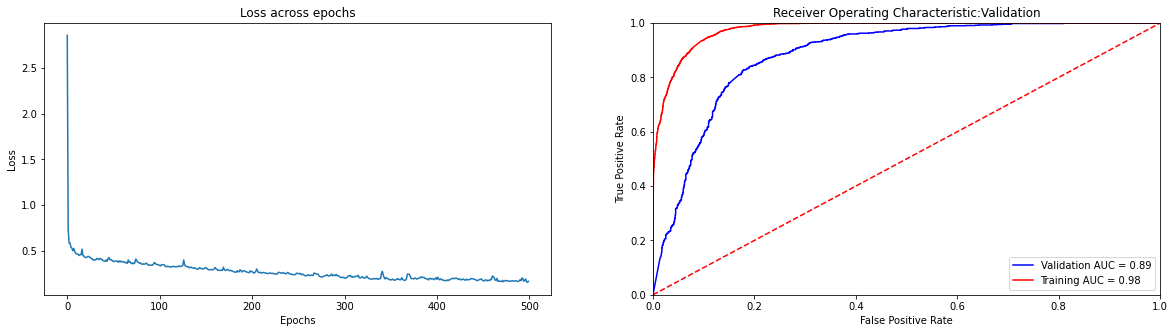

In [ ]:
num_epochs = 500
batch_size= 128
loss_function = nn.BCELoss() #Binary Crosss Entropy Loss
#Hyperparameters
weight_decay=0.0 #set to 0; no L2 Regularizer; passed into the

lambda_L1=0.0 #Set to 0; no L1 reg; manually added in loss

#Create a model instance
model = NeuralNetwork()
#Define optimizer
adam_optimizer = tch.optim.Adam(model.parameters(), lr= 0.001, weight_decay=weight_decay)
#Train model
adam_loss = train_network(model,adam_optimizer,loss_function,num_epochs,batch_size,X_train,Y_train,lambda_L1=0.0)
#Evaluate model
evaluate_model(model,x_test,y_test,X_train,Y_train,adam_loss)

In [1]:
#L2 Regularization
num_epochs = 500
batch_size= 128
weight_decay=0.001 #Enables L2 Regularization
lambda_L1 = 0.00 #Set to 0; no L1 reg
model = NeuralNetwork()
loss_function = nn.BCELoss() #Binary Crosss Entropy Loss
adam_optimizer = tch.optim.Adam(model.parameters(),lr= 0.001,
weight_decay=weight_decay)
#Train Network
adam_loss = train_network(model,adam_optimizer,loss_function,
num_epochs,batch_size,X_train,Y_train,lambda_L1=lambda_L1)
#Evaluate model
evaluate_model(model,x_test,y_test,X_train,Y_train,adam_loss)

NameError: ignored